# Automated IVC Filter Detection

This toturial builds off many of the techniques to search for the presence of an inferior vena cava (IVC) filter within abdominal CTs. 

## Load Packages and Helper Functions
Use the NiBabel package to read in NIFTI files, another common medical imaging filetype.

In [2]:
%matplotlib inline
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import dicom
import nibabel as nifti
import os
import glob
import operator
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.filters import gaussian
from skimage.feature import match_template
from skimage.feature import peak_local_max
from sklearn.cluster import KMeans

In [3]:
def readScan(fileList, imgType='DICOM', new_spacing=[5,1,1]):
    #Read a DICOM stack - fileList is a directory
    if imgType == 'DICOM':
        # Read in all of the slices
        slices = [dicom.read_file(s) 
            for s in glob.glob(fileList + '/*.dcm')]
        slices.sort(key = lambda x: int(x.InstanceNumber))
        
        #Get the slice thickness and pixel spacing
        try:
            slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - 
                                     slices[1].ImagePositionPatient[2])
        except:
            slice_thickness = np.abs(slices[0].SliceLocation - 
                                     slices[1].SliceLocation)
        
        pixel_spacing = slices[0].PixelSpacing
        
        
        # Get the slope and intercept
        intercept = slices[0].RescaleIntercept
        slope = slices[0].RescaleSlope
        
        # Make them a numpy array
        image = np.stack([s.pixel_array for s in slices])
        image = image.astype(np.int16)
        
        # Set outside-of-scan pixels to air
        # The intercept is usually -1024, so air is approximately 0
        image[image < 0] = 0

        #Convert to Hounsfield units (HU)
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)

        image += np.int16(intercept)

    #Read a NIFTI image - fileList is a file
    elif imgType == 'NIFTI':
        niftiData = nifti.load(fileList)
        
        #Get the slice thickness and pixel spacing
        slice_thickness = niftiData.header.get_zooms()[2]
        pixel_spacing = list(niftiData.header.get_zooms()[:2])
        
        # Get the slope and intercept
        intercept = niftiData.dataobj.inter
        slope = niftiData.dataobj.slope
        
        #Get the actual image data
        image = np.array(niftiData.dataobj)
        #Shift the axis order to match what we expect (z,x,y) and
        #adjust to (0,0) in the upper right
        image = np.rollaxis(image, 2, 0)
        image = np.fliplr(np.flipud(np.swapaxes(image,1,2)))

    # Calculate the desired resampling
    spacing = np.array(list(map(float, [slice_thickness] + 
                                        pixel_spacing)))

    resize_factor = spacing / new_spacing
    new_shape = np.round(image.shape * resize_factor)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    return scipy.ndimage.interpolation.zoom(image, real_resize_factor)

The readScan function reads the scan images from a directory, and if desired, resamples them. It can handle DICOM files (default) or NIFTI. <br>
 The default is to resample at 1x1 mm in-plane resolution with 5 mm slices.
<br><br>
We also need a function to remove objects outside the patient's body, like the CT table, that could confuse our algorithm when we are further along. While we are at it, let's crop the image to save storage space.

In [4]:
def segmentationCrop(scan):
    newScan = np.zeros(scan.shape).astype(np.int16) + np.min(scan)
    scanMask = np.zeros(scan.shape).astype(np.int16)
    
    # We have to do the segmentation one slice at a time.
    for i in range(scan.shape[0]):
        image = scan[i,:,:]
        # First normalize the pixel values
        img = (image - np.mean(image)) / np.std(image)
        
        # We know the patient should be approximately centered. Use this
        # to find the average of soft-tissue (we are not in the lungs)
        row_size = img.shape[0]
        col_size = img.shape[1]
        middle = img[int(col_size/5):int(col_size/5*4),
                     int(row_size/5):int(row_size/5*4)] 

        # Use k-means clustering to separate air from tissue
        kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,
                       [np.prod(middle.shape),1]))
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(img<threshold,1.0,0.0)
    
        # Using the thresholded image, first erode away the finer elements 
        # then dilate to include some of the voxels surrounding the lung base.  
        eroded = morphology.erosion(thresh_img,np.ones([3,3]))
        dilation = morphology.dilation(eroded,np.ones([8,8]))
    
        # Group connected regions. We have to add 1 to the dilation image as
        # measure.label ignores all 0 values (not sure why they did this)
        labels = measure.label(dilation + np.int16(1))
        regions = measure.regionprops(labels,image)
        
        # Create the list of regions we want to exclude. We will exclude any region that 
        # has a mean value below -100 or is really small
        outside = []
        for prop in regions:
            if prop.mean_intensity < -100 or prop.area < 200:
                outside.append(prop.label)
        amask = np.zeros([row_size, col_size]).astype(np.int16)
    
        # Finally, combine the areas we don't want into an anti-mask and then invert
        for N in outside:
            amask = amask + np.where(labels==N,1,0)
        scanMask[i,:,:] = np.int16(1) - amask
        newScan[i,:,:] = scan[i,:,:] * scanMask[i,:,:]
    
    # Now find the 3D bounding box of the mask and crop the
    # original image to that size
    bbox = measure.regionprops(scanMask)[0].bbox
    
    return newScan[bbox[0]:bbox[3],bbox[1]:bbox[4],bbox[2]:bbox[5]]

Finally, we also want a function to help us visualize the images. We are going to make this flexible such that we can zoom (or crop) to see the area of interest.

In [5]:
def plotScan(scan, start_with, show_every, rows=3, cols=4, box = None):    
    fig,ax = plt.subplots(rows, cols, figsize=[3*cols,3*rows])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/cols), int(i%cols)].set_title('slice %d' % ind)
        ax[int(i/cols), int(i%cols)].axis('off')
        
        #Draw the scan cropping to the provided box
        if box:
            clipScan = scan[ind,box[2]-1:box[5],
                            box[1]-1:box[4]]
            ax[int(i/cols), int(i%cols)].imshow(clipScan,cmap='gray')
        else:
            ax[int(i/cols), int(i%cols)].imshow(scan[ind],cmap='gray')
    plt.show()

Let's test out our functions to this point. We will read in a DICOM scan with an IVC filter that is part of **The Cancer Genome Atlas Liver Hepatocellular Carcinoma (TCGA-LIHC)** data collection, segment and crop it, and save the results for easy use in the future. 
<br><br>
Numpy has a compressed format that can save a lot of space. The combination of cropping and compression can result in a file size reduction of almost 90% (in this example 46 Mb to 6.4 Mb).

In [7]:
dataDir = 'data/1.3.6.1.4.1.14519.5.2.1.3983.4008.335698561314795862034766172231/1.3.6.1.4.1.14519.5.2.1.3983.4008.780254231471620022150012244440'
scan = readScan(dataDir, imgType='DICOM')
processedScan = segmentationCrop(scan)
np.savez_compressed(dataDir + '/Image.npz', data=processedScan)

Next, we will plot the images to see how they look. Notice the close cropping of the image to the patient.

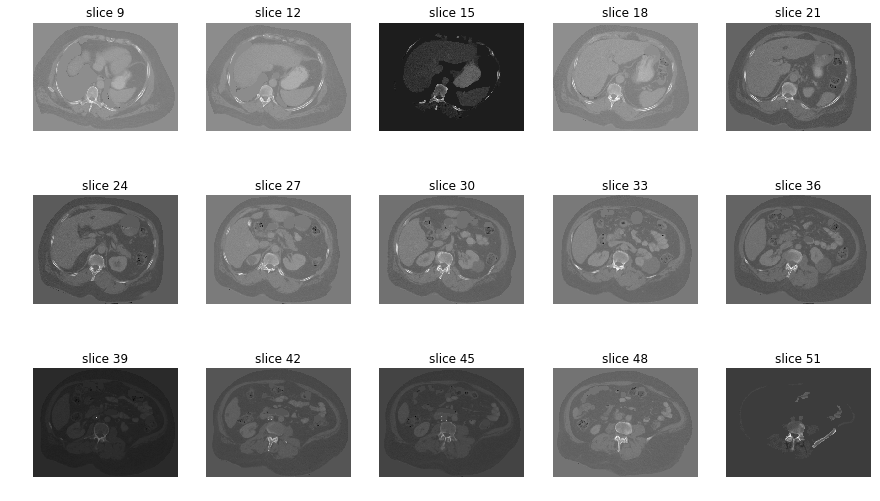

In [8]:
plotScan(processedScan, 9, 3, cols=5)

## Creating a Template
Similar to facial recognition algorithms, we are going to start by creating a template image. If we really wanted to get fancy, we could use techniques such as Principle Component Analysis (PCA) to create an "EigenImage" but here we are just going to do a smoothed average.
<br><br>
This process takes a bit of manual labor, but only has to be done once. We will step through how to do it with a single scan, but then use a template I previously created that combines 5 scans.
<br><br>
While I said above that for IVC filters we really only need 5 mm slices, for template creation 1x1x1 mm slices is helpful to extract the filter from the surrounding tissue. Let's reload this dataset and change the re-slicing.

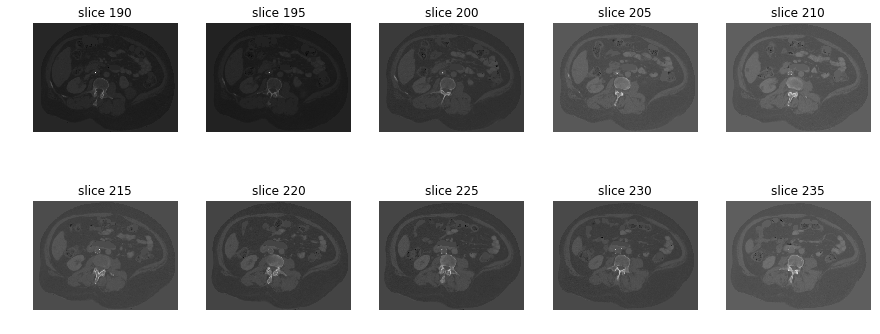

In [9]:
scanFull = readScan(dataDir, imgType='DICOM', new_spacing=[1,1,1])
processedScanFull = segmentationCrop(scanFull)
plotScan(processedScanFull, 190, 5, rows=2, cols=5)

First, look at the above 10 images to see where the IVC filter is located. It is a bit hard to see even when limited to the slices of interest. This is why the ** *plotScan* ** function has an option of a box to crop/zoom.

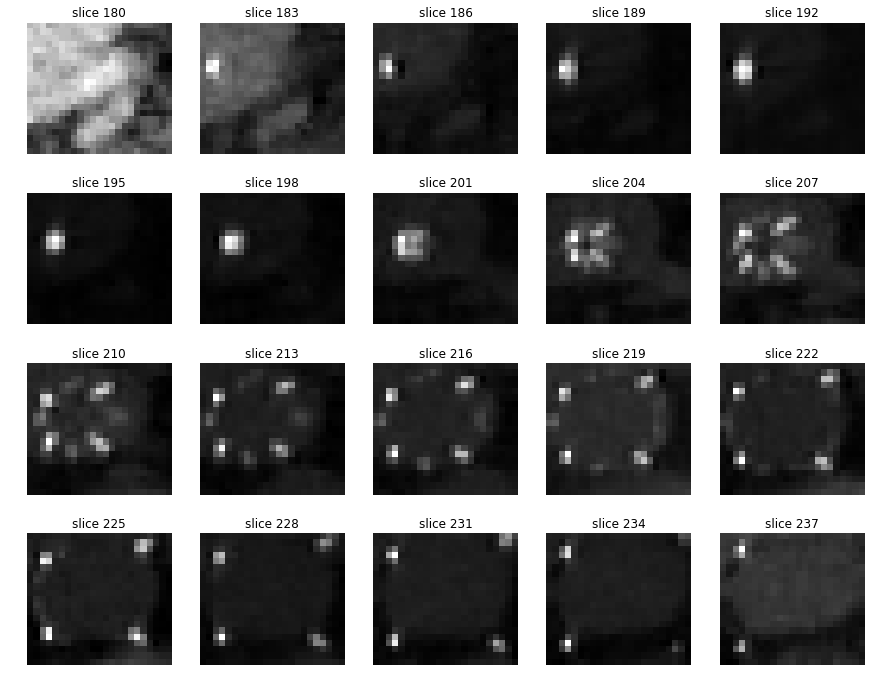

In [10]:
clip = [180, 198, 152, 240, 220, 172] #z1, x1, y1, z2, x2, y2
plotScan(processedScanFull, 180, 3, rows=4, cols=5, box=clip)

Now that we have located the filter we want to capture only the filter and ignore the rest. Using the same functions we did in the initial scan import, we will first threshold the image to 300 HU (can be variable) and then use the scikit-image ** *label* ** and ** *egionprops* ** functions to clip to the filter

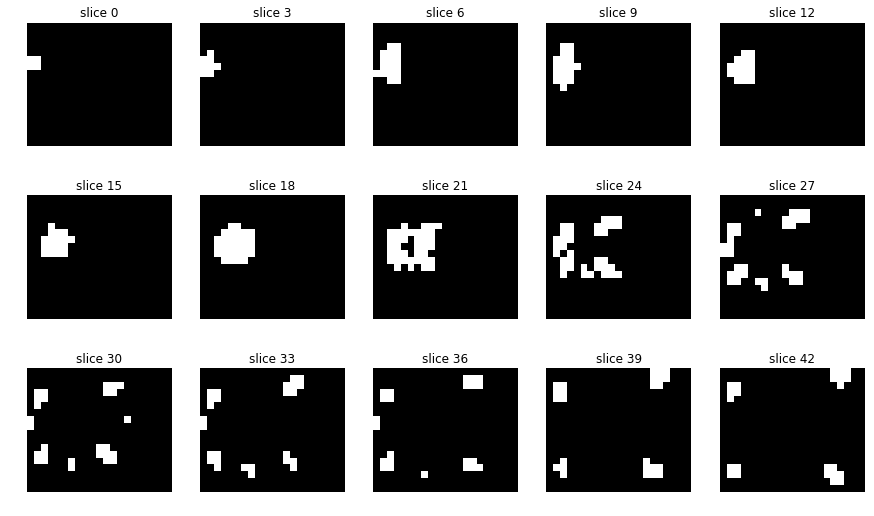

In [11]:
refImg = processedScanFull[clip[0]:clip[3],clip[2]:clip[5],clip[1]:clip[4]]
threshImg = refImg > 300 #threshold
labels = measure.label(threshImg)
labelImg = np.where(labels == 1, 1, 0)
bbox = measure.regionprops(labelImg)[0].bbox
filterImg = threshImg[bbox[0]:bbox[3],bbox[1]:bbox[4],bbox[2]:bbox[5]]
plotScan(filterImg, 0, 3, cols=5)

The problem with this thresholded image is that small differences in position/rotation of the filter lead to very different distributions of the filter tines. Smoothing can help with this. Let's start with a 2mm Gaussian filter using ** *skimage.filters.gaussian* **

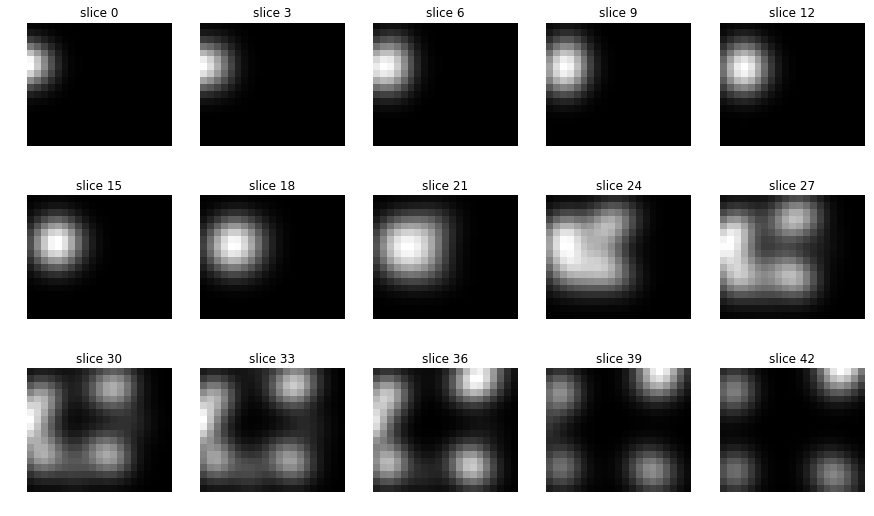

In [12]:
smoothFilterImg = gaussian(filterImg, sigma=2) #2mm kernel
plotScan(smoothFilterImg, 0, 3, cols=5)

Now we can start to see a more generic shape of a filter that is less dependent on exact orientation.
<br><br>
We would perform the same steps on other scans to create a bunch of single-subject templates. However, a more realistic filter template would combine images from multiple filters. Below is the template I created from 5 separate scans. To combine them, I performed the following steps:

* Align using scikit-image's center_of_mass function
* Pad each scan until they are all the same size
* Average them at each voxel
* Clip the final template using the bounding box from skimage.measure.regionprops

The general "energy density" of a filter becomes aparent in both axial and coronal views

In [ ]:
template = np.load('../Templates/double-5x2x2-2mmSmooth.npz')['arr_0']
plotScan(template, 0, 3, rows=2, cols=5)
plotScan(template.swapaxes(0,1), 0, 2, rows=2, cols=5)

## Filter Detection

Now that we have built a template we can start to see how it might work in a detection algorithm. A caveat before we begin: there are many additional processing steps that we could layer on to improve the algorithm's accuracy. To keep this relatively simple we are not going to perform any additional processing of the scan itself, though intensity filtering, location validation and information from dual-energy scanners are all possible.
<br><br>
The main technique we will use in this algorithm is to perform a correlation calculation of the template as it moves across a scan (in 3D). We then look for areas of maximum correlation, subject to a few restrictions:

* The correlation value must be at least 0.5
* We do not allow a maximum correlation to be within 5 voxels of the edge of the image
* We require at least some metal in the matched region, but to exclude bone (and because we know the filter is hollow in the middle) the area cannot be all really dense

In [ ]:
def detection(scan,template,kernel=[0.4,2,2]):
    # Threshold to highlight dense areas. Then smooth with a 2mm Gaussian filter
    searchScan =  gaussian((scan > 300).astype(np.float64), kernel, 
                            mode='constant')
    
    # Try to match the template to the scan. The output is the same
    # size as scan, and is the correlation. Peaks in the output are areas 
    # of more likely match
    corr = match_template(searchScan, template, pad_input=True, mode='constant')
    
    maxCoords = peak_local_max(corr, min_distance=20, threshold_abs=0.5,
                         indices=True, exclude_border=5)
    
    maxVals = []
    for i in range(len(maxCoords)):
        # Check that there is enough high-density stuff to suggest a filter,
        # but not so much as to be all bone or other metallic object (e.g. LVAD device)
        pixels = np.sum(cropScan(scan,template,maxCoords[i],size=1)>500)
        metal = np.sum(cropScan(scan,template,maxCoords[i],size=1)>1000)
        if pixels < 400 and metal > 10:
            maxVals.append([corr[maxCoords[i][0],maxCoords[i][1],
                                 maxCoords[i][2]],maxCoords[i]])
    
    return corr, sorted(maxVals, key=operator.itemgetter(0), reverse=True)

#Helper function to use the template as a mask
def cropScan(scan,template,coords,size=1.2):
    minz = int(coords[0] - ceil(size*template.shape[0]/2))
    maxz = int(coords[0] + ceil(size*template.shape[0]/2))
    miny = int(coords[1] - ceil(size*template.shape[1]/2))
    maxy = int(coords[1] + ceil(size*template.shape[1]/2))
    minx = int(coords[2] - ceil(size*template.shape[2]/2))
    maxx = int(coords[2] + ceil(size*template.shape[2]/2))
    
    return scan[minz:maxz,miny:maxy,minx:maxx]

Let's go back to the scan above at the 5x1x1 mm sampling. How does our detection do?

In [ ]:
corr, maxVals = detection(processedScan, template)
maxVals

So we can see that there is one (and only one) region with a correlation value of almost 0.64. Let's plot the image slice at that coordinate with a red dot at point of detection.

In [ ]:
plt.imshow(processedScan[maxVals[0][1][0]], cmap='gray')
plt.axis('off')
plt.plot(maxVals[0][1][2], maxVals[0][1][1], 'or')

We can see that, in this case, the algorithm found the filter and only the filter. Note that sometimes multiple matches will be found. A more advanced algorithm would have a procedure for selecting which one is best. Right now, this algorithm simply takes the one with the highest correlation value.

A true test of this algorithm is to run it on multiple subjects with filtes and multiple subjects without filters. The problem with the sample dataset from The Cancer Genome Atlas Liver Hepatocellular Carcinoma (TCGA-LIHC) data collection is that most subjects do not have filters (though I guess this is similar to the distribution in real-world radiology).

I tried this algorithm in 48 subjects from my internal dataset, 24 with filters and 24 without, and used a correlation cutoff of at least 0.62. This resulted in a sensitivity and specificity of around 80% each. Not bad, but definitely room for improvement.

<table>
    <tbody>
        <tr>
            <td></td>
            <td></td>
            <th colspan="2" align="center">Filter Present</th>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td align="center">Yes</td>
            <td align="center">No</td>
        </tr><tr>
            <th rowspan="2" align="center">Algorithm</th>
            <td align="center">Yes</td>
            <td align="center">19</td>
            <td align="center">4</td>
       </tr>
       <tr>
           <td align="center">No</td>
           <td align="center">5</td>
           <td align="center">20</td>
       </tr>
       <tr>
           <td></td>
           <td></td>
           <td align="center">Sens=0.79</td>
           <td align="center">Spec=0.83</td>
  </tr></tbody>
</table>
